In [1]:
# Basics
import numpy as np
import pandas as pd
import os

# Scipy
from scipy import optimize
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import KDTree
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator, MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

def fmt(x, pos):
    ''' Used for the x10^ for colourbars'''
    if x == 0:
        return r'0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Change which model you want to run here!

Update the ```model_to_analyse``` variable

In [83]:
model_to_analyse = 'gcmp38d'

model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/2_phase_sims/magellan3/" + model_to_analyse
os.chdir(model_path)

In [84]:
timesteps = np.load('timestep.npy')
if len(timesteps) == 3:
    no_of_steps = timesteps.size  # if no repeated time step
else:
    #no_of_steps = timesteps.size - 1 # take 1 if repeated final time step
    no_of_steps = timesteps.size

print('Timesteps of ', timesteps)

Timesteps of  [0.0000000e+00 7.0505499e+07 1.4100564e+08 2.1150564e+08 2.8200564e+08
 3.5250564e+08 3.5250564e+08]


In [85]:
col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'gid', 'mass', 'h', 'd', 'c', 'tt', 'frah', 
              'm_H', 'm_He', 'm_C', 'm_N', 'm_O', 'm_Fe', 'm_Mg', 'm_Ca', 'm_Si', 'm_S', 'm_Ba', 
              'd_H', 'd_He', 'd_C', 'd_N', 'd_O', 'd_Fe', 'd_Mg', 'd_Ca', 'd_Si', 'd_S', 'd_Ba', 'id']


df_g = [] # List of gas data frames
df_d = [] # List of disc stars data frames
df_n = [] # List of new stars data frames

for i in range(no_of_steps):

    df_g.append(pd.DataFrame(np.load('gas'+str(i)+'.npy'), columns=col_header))
    
    df_d.append(pd.DataFrame(np.load('gal'+str(i)+'.npy'), columns=col_header))
    
    # Caution for empty frames
    try: 
        df_n.append(pd.DataFrame(np.load('new'+str(i)+'.npy'), columns=col_header))
    except:
        df_n.append(-1)


In [86]:
path = "1_output_visualisation"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
    
    
os.chdir(path)
print('Current directory:', os.getcwd())

Creation of the directory 1_output_visualisation failed
Current directory: /Users/maddie/Desktop/Thesis/Simulation_output/2_phase_sims/magellan3/gcmp38d/1_output_visualisation


In [71]:
def make_hist(df, i, rang, bin_size, f, timestep):
    ''' Make a histogram for a given time step'''
    
    try:
        bin1, xedges, yedges = np.histogram2d(df[i].x, df[i].y, bins = bin_size, weights = df[i].mass, range=([-rang,rang],[-rang,rang]))
        bin2, xedges, yedges = np.histogram2d(df[i].x, df[i].z, bins = bin_size, weights = df[i].mass, range=([-rang,rang],[-rang,rang]))
    except:
        return
    
    props = dict(facecolor='white',alpha=0.9)  
    
    gamma = 0.5

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(14,6)
    
    ax[0].imshow(bin1.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang])
    ax[0].hlines(0,-5,5, 'r')
    ax[0].vlines(0,-5,5, 'r')
    ax[0].set_ylabel('Y')
    ax[0].set_xlabel('X')

    ax[1].imshow(bin2.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang])
    ax[1].hlines(0,-5,5, 'r')
    ax[1].vlines(0,-5,5, 'r')
    ax[1].set_ylabel('Z')
    ax[1].set_xlabel('X')
    ax[1].text(-1700, 1500, 'T =' + str(np.round(timestep/10**6, 2)) + ' Myr', bbox=props)
    
    file_id = f + '_'+ str(i)
    plt.savefig("XY_projection_" + file_id, bbox_inches='tight', dpi = 300)
    plt.close()
    #plt.show()

## Output histograms of the components

Current settings of 

```rang = 2000
bin_size = 400
```

work well. 

If you change this, you have to change the max and min values later on.

In [51]:
# For visualising the entire galaxy
rang = 2000
bin_size = 400

### The gas, disc stars and new stars:

In [52]:
for i in range(no_of_steps):
    make_hist(df_g, i, rang, bin_size, 'gas', timesteps[i])
    
    
for i in range(no_of_steps):
    make_hist(df_d, i, rang, bin_size, 'disc', timesteps[i])


for i in range(no_of_steps):
    make_hist(df_n, i, rang, bin_size, 'new', timesteps[i])

## Clump finding algorithm

In [121]:
def remove_rad(hist, x, y, rad):
    ''' Removes pixels from the 2D histogram so they cant be chosen next time '''
    for i in range(x-rad, x+rad):
        for j in range(y-rad, y+rad):
            try:
                hist[i][j] = -100
            except:
                continue
    return hist

def volume_density(rad, mass):
    ''' Estimates the volume density of each potential clump'''
    max_r = 200
    
    bin_sums, bin_edges, binnumber = stats.binned_statistic(rad, mass, statistic='sum', bins=int(max_r/10), range = [0,max_r])

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2


    r = bin_edges
    volume = (4/3) * np.pi * r**3
    volume_differences = volume[1:] - volume[:-1]
    sigma = bin_sums/volume_differences
    #fig, ax  = plt.subplots()
    #plt.plot(r[1:], sigma, '.')
    #plt.show()
    
    add_clump = True
    
    # If the central bin is under a certain density, don't add it
    if sigma[0] < 10:
        print('does not satisfy central density')
        add_clump = False
    
    
    # Return as soon as you find a density less than 1 Msun pc^3
    for i in range(len(sigma)):
        
        
        # Find density threshold
        if sigma[i] < 1: 
            
            # Check that mass is above the threshold
            mass = np.sum(mass[rad < r[i+1]])
            print('Mass is: ', mass)
            if mass < 5e5:
                print('does not satisfy mass')
                add_clump = False
                
                
            # Clump surface density must be monotonically decreasing
            j = i
            while j > 0:
                if sigma[j] > sigma[j-1]:
                    print('does not satisfy monotonically decreasing')
                    add_clump = False
                j-= 1 # decrement by 1
            
            # return output of whether it's a clump
            return r[i+1]+50, add_clump # Extra +50 to make sure all is removed
        
    # If there was no radii within 200 pc < this, don't add a clump
    return r[-1], False # return 200 pc radius
    

    
def refine_max(df, m_x, m_y):
    
    # Range to perform the KDE on
    i = 130 # Not too big to avoid points which are a max at the edge
    
    # Centering on the clump guess
    df = df.assign(x_scale = df.x -  m_x)
    df = df.assign(y_scale = df.y -  m_y)
    
    # taking searching radii
    df_crop = df.loc[(df.y_scale<i)&(df.y_scale>-i)& \
                     (df.x_scale<i)&(df.x_scale>-i)& \
                     (df.z<i)      &(df.z>-i)]
    
    # Stacking together for KDE
    xyz = np.vstack([df_crop.x_scale, df_crop.y_scale, df_crop.z])
    kde = stats.gaussian_kde(xyz, weights = df_crop.mass, bw_method = 'silverman')
    density = kde(xyz)
    
    # Extracting the maximum density points
    max_density = np.argmax(density)
    max_dense_x = df_crop.x_scale.iloc[max_density]
    max_dense_y = df_crop.y_scale.iloc[max_density]
    max_dense_z = df_crop.z.iloc[max_density]
    
    # Rescaling based on the point
    df_crop = df_crop.assign(x_scale = df_crop.x_scale - max_dense_x)
    df_crop = df_crop.assign(y_scale = df_crop.y_scale - max_dense_y)
    df_crop = df_crop.assign(z_scale = df_crop.z - max_dense_z)
    df_crop = df_crop.assign(r_scale = np.power(df_crop.x_scale**2 + df_crop.y_scale**2 + df_crop.z_scale**2, 0.5))
    
    
    # Calling volume density function
    radii, add_clump = volume_density(df_crop.r_scale,df_crop.mass)
    
    
    return radii, add_clump

    
    

def get_max(hist, df, num_points):
    ''' Goes through a 2D histogram and iterativly selects points 
    with the highest density in a given bin'''
    max_points_x = []
    max_points_y = []
    max_points_z = []
    
    # Cut off not big enough for nucleus
    found_nucleus = False
    nuc_cut =300 # Custom rad for nucleus
    
    # All the potential clump candidates
    for i in range(num_points):
        print('Up to clump ', i)
        
        # Find where the histogram is at it's max
        max_result = np.where(hist == np.amax(hist))
        max_x_rm = max_result[0][0]
        max_y_rm = max_result[1][0]
        
        # Take them out of imshow coordinates 
        max_x_coords = (max_x_rm * 10) - 2000
        max_y_coords = (max_y_rm * 10) - 2000
        
        # If we have already come across the nucleus
        if max_x_coords < nuc_cut and max_x_coords > -nuc_cut and max_y_coords < nuc_cut and \
            max_y_coords > -nuc_cut and not found_nucleus:
            # Say we have found the nucleus and keep going
            found_nucleus = True
        elif max_x_coords < nuc_cut and max_x_coords > -nuc_cut and max_y_coords < nuc_cut and \
            max_y_coords > -nuc_cut and found_nucleus:
            # remove that area and skip to the next clump
            hist = remove_rad(hist, max_x_rm, max_y_rm, 20)
            continue
        
        # Get a better estimate of whether it's a clump
        radii, add_clump = refine_max(df, max_x_coords, max_y_coords)
        
        # Remove radii
        #print('removing radii: ', radii)
        hist = remove_rad(hist, max_x_rm, max_y_rm, int(radii/10))
        
        # If it's not a clump, remove region and keep going
        if not add_clump:
            print("Skipping clump")
            continue
        
        # Otherwise append it to lists to return
        max_points_x.append(max_x_rm)
        max_points_y.append(max_y_rm)

    
    max_points_x = np.asarray(max_points_x)
    max_points_y = np.asarray(max_points_y)

    return hist, max_points_x, max_points_y

def hist_visualisation(new_gas_hist):
    ''' Used to visualise the histogram after the dencest points have been removed
    Mostly used as a sanity check'''
    gamma = 0.3

    fig, ax = plt.subplots(1,1)
    ax.imshow(new_gas_hist.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang])
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    plt.savefig("clump_search_check", bbox_inches='tight', dpi = 300)
    plt.show()
    

Calling it for the final time step to check where the clumps are at.

Using the same values for the bins and range as the previous outputs.


```get_max(gas_hist, 12)``` passes the gas histogram that was just created and returns the 12 highest density clumps.

Have to scale the max_x and y points after in order to get them in terms of pc and not with respect to the dimentions of the 2D histogram.

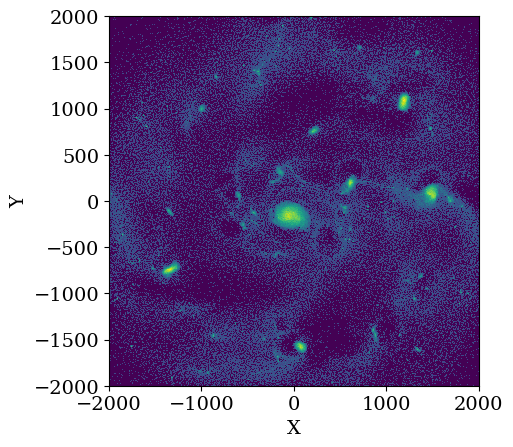

Up to clump  0
Mass is:  24602400.0
Up to clump  1
Mass is:  20698200.0
Up to clump  2
Mass is:  73556100.0
Up to clump  3
Mass is:  12652200.0
Up to clump  4
Mass is:  11067300.0
Up to clump  5
Mass is:  30148200.0
Up to clump  6
Mass is:  3793500.0
Up to clump  7
does not satisfy central density
Mass is:  405000.0
does not satisfy mass
Skipping clump
Up to clump  8
Mass is:  167400.0
does not satisfy mass
Skipping clump
Up to clump  9
Mass is:  199800.0
does not satisfy mass
Skipping clump
Up to clump  10
Mass is:  1031400.0
Up to clump  11
Mass is:  143100.0
does not satisfy mass
Skipping clump
Up to clump  12
Mass is:  610200.0
Up to clump  13
Mass is:  1733400.0
Up to clump  14
Mass is:  243000.0
does not satisfy mass
Skipping clump
Up to clump  15
Mass is:  218700.0
does not satisfy mass
Skipping clump
Up to clump  16
Mass is:  132300.0
does not satisfy mass
Skipping clump
Up to clump  17
Mass is:  1387800.0
Up to clump  18
Mass is:  226800.0
does not satisfy mass
Skipping clump


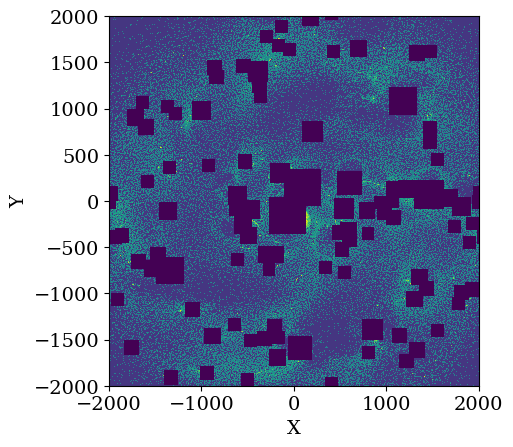

In [122]:
rang = 2000
bin_size = 400

timeStep = -1
gas_final = df_g[timeStep]
# For the previous time step
#gas_hist, xedges, yedges = np.histogram2d(df_g[-1].x, df_g[-1].y, bins = bin_size, weights = df_g[-1].mass, range=([-rang,rang],[-rang,rang]))

# other time steps
gas_hist, xedges, yedges = np.histogram2d(df_g[timeStep].x, df_g[timeStep].y, bins = bin_size, weights = df_g[timeStep].mass, range=([-rang,rang],[-rang,rang]))
hist_visualisation(gas_hist)
new_gas_hist, max_x, max_y= get_max(gas_hist,gas_final, 100)
hist_visualisation(new_gas_hist) # Used to visualise


max_x = (max_x * 10) - 2000
max_y = (max_y * 10) - 2000

In [100]:
len(max_x)

25

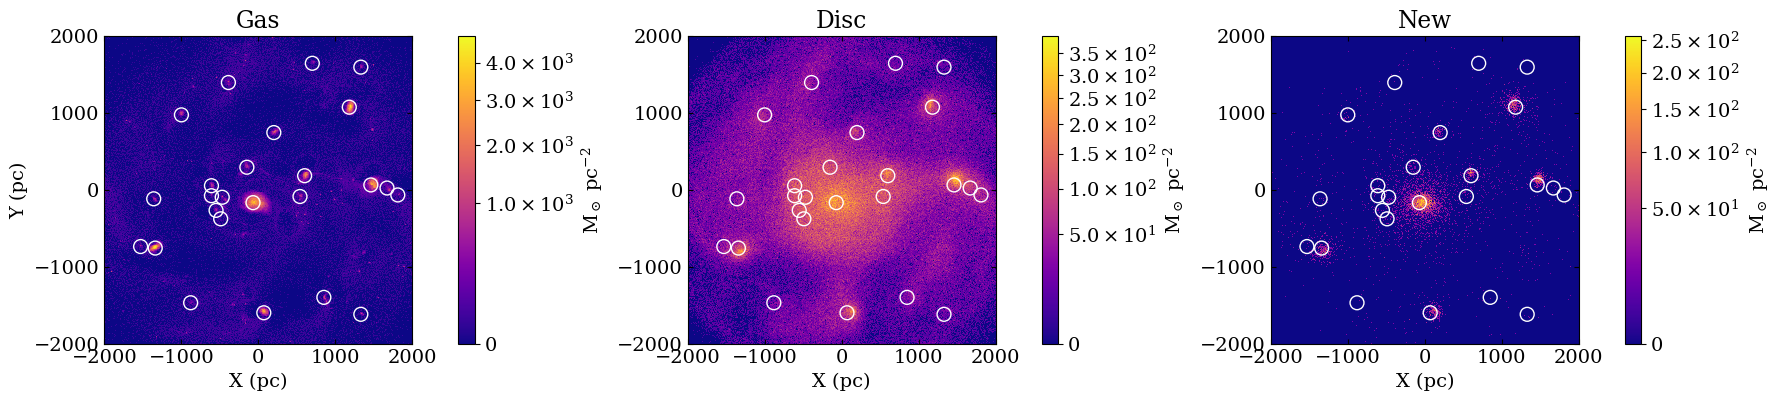

In [101]:
# For visualising the entire galaxy
rang = 2000
bin_size = 400



hist1, xedges, yedges = np.histogram2d(df_g[timeStep].x, df_g[timeStep].y, bins = bin_size, weights = df_g[timeStep].mass, range=([-rang,rang],[-rang,rang]))
hist2, xedges, yedges = np.histogram2d(df_d[timeStep].x, df_d[timeStep].y, bins = bin_size, weights = df_d[timeStep].mass, range=([-rang,rang],[-rang,rang]))
try: 
    hist3, xedges, yedges = np.histogram2d(df_n[timeStep].x, df_n[timeStep].y, bins = bin_size, weights = df_n[timeStep].mass, range=([-rang,rang],[-rang,rang]))
except:
    hist3, xedges, yedges = np.histogram2d([0,0], [0,0], bins = bin_size, range=([-rang,rang],[-rang,rang]))

gamma = 0.5
cmap = plt.cm.get_cmap('plasma')

fig = plt.figure()
fig.set_size_inches(20,4)
gs = gridspec.GridSpec(1,8, width_ratios=[1, 0.05, 0.4, 1, 0.05, 0.4, 1, 0.05])  
cbax1 = plt.subplot(gs[1])
cbax2 = plt.subplot(gs[4])
cbax3 = plt.subplot(gs[7])

ax0 = plt.subplot(gs[0]) # top left
ax1 = plt.subplot(gs[3]) # top middle
ax2 = plt.subplot(gs[6]) # top right


# Gas
im1 =ax0.imshow(hist1.T/100, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax0.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax0.set_ylabel('Y (pc)')
ax0.set_xlabel('X (pc)')
ax0.set_title('Gas')

# Disc
im2 = ax1.imshow(hist2.T/100, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_xlabel('X (pc)')
ax1.set_title('Disc')

# New
im3 = ax2.imshow(hist3.T/100, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax2.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax2.set_xlabel('X (pc)')
ax2.set_title('New')

cb1 = Colorbar(ax = cbax1, mappable = im1 , format=ticker.FuncFormatter(fmt))
cb2 = Colorbar(ax = cbax2, mappable = im2 , format=ticker.FuncFormatter(fmt))
cb3 = Colorbar(ax = cbax3, mappable = im3 , format=ticker.FuncFormatter(fmt))

cb1.set_label(r'M$_\odot$ pc$^{-2}$')
cb2.set_label(r'M$_\odot$ pc$^{-2}$')
cb3.set_label(r'M$_\odot$ pc$^{-2}$')

ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax2.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

plt.savefig('clump_search', bbox_inches='tight', dpi = 300)
plt.show()

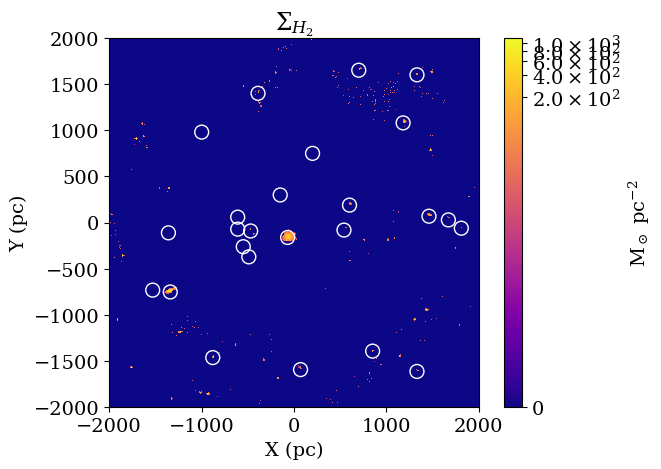

In [102]:
gamma = 0.3
hist1, xedges, yedges = np.histogram2d(df_g[timeStep].x, df_g[timeStep].y, bins = bin_size, weights = df_g[timeStep].mass * df_g[timeStep].frah, range=([-rang,rang],[-rang,rang]))
fig, ax1 = plt.subplots()
im2 = ax1.imshow(hist1.T/100, norm=mcolors.PowerNorm(0.1), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)

cbar = fig.colorbar(im2, ax=ax1, format=ticker.FuncFormatter(fmt))
ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_ylabel('Y (pc)')
ax1.set_xlabel('X (pc)')
ax1.set_title('$\Sigma_{ H_2 }$')
cbar.set_label(r'M$_\odot$ pc$^{-2}$')
plt.savefig('H2_circle', bbox_inches='tight', dpi = 300)
plt.show()

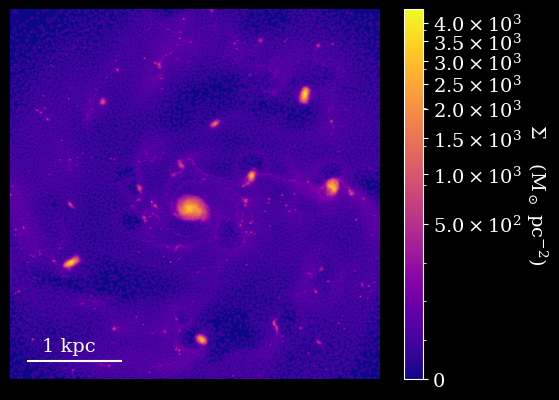

In [103]:
rang = 2000
bin_size = 4000

gamma = 0.4
hist1, xedges, yedges = np.histogram2d(df_g[-1].x, df_g[-1].y, bins = bin_size, weights = df_g[-1].mass, range=([-rang,rang],[-rang,rang]))
smoothing_sigma = 6
hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
plt.style.use('dark_background')
fig, ax1 = plt.subplots()



im2 = ax1.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax1.plot([-1800,-800], [-1800, -1800], color='white')
cbar = fig.colorbar(im2, ax=ax1, format=ticker.FuncFormatter(fmt))
#ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_ylabel('Y (pc)')
ax1.set_xlabel('X (pc)')
#ax1.set_title('$\Sigma_{ H_2 }$')
cbar.set_label(r'$\Sigma $    (M$_\odot$ pc$^{-2}$)', rotation=270, labelpad = 20)
plt.axis('off')
cbar.ax.minorticks_on()
ax1.text(-1650, -1700, '1 kpc')
plt.savefig('dark_gas', bbox_inches='tight', dpi = 300)
plt.show()

In [104]:
plt.style.use('default')
# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

## Looking at specific clumps

Changing the bining range to be in line with a 100 pc GMC

In [21]:
def z_estimate(df):
    rng = 100
    hist, xedges, yedges = np.histogram2d(df.x_scale, df.z, weights = df.mass, bins = rng*2,range=([-rng,rng],[-rng,rng]))
    
    max_result = np.where(hist == np.amax(hist))
    max_x_rm = max_result[0][0]
    max_z_rm = max_result[1][0]

    # Take them out of imshow coordinates 
    max_x_coords = max_x_rm - rng
    max_z_coords = max_z_rm - rng
    print('z estimate function ', max_x_coords, max_z_coords)
    return max_z_coords
    

def center_clump(df, x, y, z = 0):
    ''' Adds a column centred on the clump'''
    df = df.assign(x_scale = df.x - x)
    df = df.assign(y_scale = df.y - y)
    if z ==0:
        z = z_estimate(df)
        df = df.assign(z_scale = df.z - z)
    else:
        df = df.assign(z_scale = df.z - z)
    return df, z

def clump_crop(df, rng):
    ''' Return only particles within a certain radius'''
    return df[(df.x_scale < rng) & (df.x_scale > -rng) & (df.y_scale < rng) & (df.y_scale > -rng) & (df.z_scale < rng) & (df.z_scale > -rng)]

def clump_plot(g, d, n):
    ''' Smoothed histogram of a 100 pc box around the clump region '''
    hist1, xedges, yedges = np.histogram2d(g.x_scale, g.y_scale, bins = bin_size, weights = g.mass, range=([-rang,rang],[-rang,rang]))
    hist2, xedges, yedges = np.histogram2d(d.x_scale, d.y_scale, bins = bin_size, weights = d.mass, range=([-rang,rang],[-rang,rang]))
    hist3, xedges, yedges = np.histogram2d(n.x_scale, n.y_scale, bins = bin_size, weights = n.mass, range=([-rang,rang],[-rang,rang]))

    gamma = 0.8
    cmap = plt.cm.get_cmap('plasma')

    # Smooooth
    smoothing_sigma = 10
    hist1 = gaussian_filter(hist1, sigma=smoothing_sigma)
    hist2 = gaussian_filter(hist2, sigma=smoothing_sigma)
    hist3 = gaussian_filter(hist3, sigma=smoothing_sigma)


    fig = plt.figure()
    fig.set_size_inches(20,4)


    gs = gridspec.GridSpec(1,8, width_ratios=[1, 0.05, 0.4, 1, 0.05, 0.4, 1, 0.05])  
    cbax1 = plt.subplot(gs[1])
    cbax2 = plt.subplot(gs[4])
    cbax3 = plt.subplot(gs[7])

    ax0 = plt.subplot(gs[0]) # top left
    ax1 = plt.subplot(gs[3]) # top middle
    ax2 = plt.subplot(gs[6]) # top right


    # Gas
    im1 =ax0.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax0.set_ylabel('Y')
    ax0.set_xlabel('X')
    ax0.set_title('Gas')

    # Disc
    im2 = ax1.imshow(hist2.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax1.set_xlabel('X')
    ax1.set_title('Disc')

    # New
    im3 = ax2.imshow(hist3.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax2.set_xlabel('X')
    ax2.set_title('New')

    cb1 = Colorbar(ax = cbax1, mappable = im1 , format=ticker.FuncFormatter(fmt))
    cb2 = Colorbar(ax = cbax2, mappable = im2 , format=ticker.FuncFormatter(fmt))
    cb3 = Colorbar(ax = cbax3, mappable = im3 , format=ticker.FuncFormatter(fmt))

    cb1.set_label(r'M$_\odot$ pc$^{-2}$')
    cb2.set_label(r'M$_\odot$ pc$^{-2}$')
    cb3.set_label(r'M$_\odot$ pc$^{-2}$')

    ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax2.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

    #plt.savefig("gas_gal_100", bbox_inches='tight', dpi = 300)
    plt.show()

## Long term evolution

Inner join on the pandas tables to check the starting locations of the clumps

In [22]:
def time_evolution(merge1, merge0, f, timestep):
    ''' Plots the evolution of the system for a given clump
    merge1: last and second last time steps
    merge0: last and first time steps'''
    
    rang = 2000
    bin_size = 400


    hist1, xedges, yedges = np.histogram2d(merge1.x_x, merge1.y_x, bins = bin_size, weights = merge1.mass_x, range=([-rang,rang],[-rang,rang]))
    hist2, xedges, yedges  = np.histogram2d(merge1.x_y, merge1.y_y, bins = bin_size, weights = merge1.mass_y, range=([-rang,rang],[-rang,rang]))
    hist3, xedges, yedges  = np.histogram2d(merge0.x_y, merge0.y_y, bins = bin_size, weights = merge0.mass_y, range=([-rang,rang],[-rang,rang]))


    cmap = plt.cm.get_cmap('plasma')
    props = dict(facecolor='white',alpha=0.9) 
    gamma = 0.3

    fig = plt.figure()
    fig.set_size_inches(18,4)
    gs = gridspec.GridSpec(1,8, width_ratios=[1, 0.05, 0.4, 1, 0.05, 0.4, 1, 0.05])  
    cbax1 = plt.subplot(gs[1])
    cbax2 = plt.subplot(gs[4])
    cbax3 = plt.subplot(gs[7])

    ax0 = plt.subplot(gs[0]) # top left
    ax1 = plt.subplot(gs[3]) # top middle
    ax2 = plt.subplot(gs[6]) # top right


    im1 =ax0.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax0.set_ylabel('Y')
    ax0.set_xlabel('X')
    ax0.text(-1850, 1650, 'T =' + str(np.round(timestep[2]/10**6, 2)) + ' Myr', bbox=props)

    im2 = ax1.imshow(hist2.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax1.set_xlabel('X')
    ax1.text(-1850, 1650, 'T =' + str(np.round(timestep[1]/10**6, 2)) + ' Myr', bbox=props)

    im3 = ax2.imshow(hist3.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
    ax2.set_xlabel('X')
    ax2.text(-1850, 1650, 'T =' + str(np.round(timestep[0]/10**6, 2)) + ' Myr', bbox=props)

    cb1 = Colorbar(ax = cbax1, mappable = im1 , format=ticker.FuncFormatter(fmt))
    cb2 = Colorbar(ax = cbax2, mappable = im2 , format=ticker.FuncFormatter(fmt))
    cb3 = Colorbar(ax = cbax3, mappable = im3 , format=ticker.FuncFormatter(fmt))

    cb1.set_label(r'M$_\odot$pc$^{-2}$')
    cb2.set_label(r'M$_\odot$pc$^{-2}$')
    cb3.set_label(r'M$_\odot$pc$^{-2}$')

    ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax2.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

    plt.savefig("clump_evolution_" + f , bbox_inches='tight', dpi = 300)
    plt.close()
    
    
def merge_timesteps(g_clump, d_clump, df_g, df_d):
    ''' Merges timesteps based on ID and then plots them '''
    
    gas_merge1 = g_clump.merge(df_g[1], left_on='id', right_on='id')
    gas_merge0 = g_clump.merge(df_g[0], left_on='id', right_on='id')

    disc_merge1 = d_clump.merge(df_d[1], left_on='id', right_on='id')
    disc_merge0 = d_clump.merge(df_d[0], left_on='id', right_on='id')
    
    time_evolution(gas_merge1, gas_merge0, 'gas', timesteps)
    time_evolution(disc_merge1, disc_merge0, 'disc', timesteps)

## Metallicity calcs

In [23]:
def make_metals(clump):
    ''' Make extra columns on a given dataframe'''
    
    # Radius from the centre of the clump
    # Note: does not account for Z! (make a KDE later?)
    clump = clump.assign(r = np.power(np.power(clump.x_scale,2) + np.power(clump.y_scale,2) + np.power(clump.z_scale,2), 0.5))

    # Metals WITH HYDROGEN
    clump = clump.assign(m_H = clump.m_H + clump.m_He + clump.m_C + clump.m_N + clump.m_O + clump.m_Fe + \
                            clump.m_Mg + clump.m_Ca + clump.m_Si + clump.m_S + clump.m_Ba)
    
    # Metals WITHOUT HYDROGEN
    clump = clump.assign(m = clump.m_C + clump.m_N + clump.m_O + clump.m_Fe + \
                            clump.m_Mg + clump.m_Ca + clump.m_Si + clump.m_S + clump.m_Ba)

    # Dust
    clump = clump.assign(d_H = clump.d_H + clump.d_He + clump.d_C + clump.d_N + clump.d_O + clump.d_Fe + \
                            clump.d_Mg + clump.d_Ca + clump.d_Si + clump.d_S + clump.d_Ba)
    
    # Dust WITHOUT HYDROGEN
    clump = clump.assign(d = clump.d_C + clump.d_N + clump.d_O + clump.d_Fe + \
                            clump.d_Mg + clump.d_Ca + clump.d_Si + clump.d_S + clump.d_Ba)

    # Total z (need to account for solar metalicity)
    clump = clump.assign(z_metal = ((clump.m + clump.d)/(clump.m_H + clump.d_H))) # solar metalicity? only if you want Z/H
    #clump = clump.assign(z_metal = ((clump.m)/(clump.m_H)))
    
    # [Fe/H] calc
    #clump = clump.assign(Fe_H = np.log10(clump.m_Fe/clump.m_H) - np.log10(0.00117/0.706) )
    clump = clump.assign(Fe_H = np.log10((clump.m_Fe + clump.d_Fe)/(clump.m_H + clump.d_H) )- np.log10(0.00117/0.706) )
    
    clump = clump.assign(He_total = (clump.m_He + clump.d_H) /(clump.m_H + clump.d_H))
    
    # H2 mass of the clump (only relavent for the gas portion)
    clump = clump.assign(H2 = clump.mass * clump.frah)
    
    # Temperature
    clump = clump.assign(temperature = 10**4 * ((121* clump.c)/10)**2)
    
    return clump

def chem_vis(clump, y_val, f):
    ''' Visualising the chemical spread'''
    fig, ax = plt.subplots()

    h = ax.hist2d(clump.r, clump[y_val], bins = 50)
    ax.set_ylabel(y_val)
    ax.set_xlabel('Radius from clump center (pc)')
    ax.set_title('Metallicity spread')
    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label('count')
    
    plt.savefig('metals_' + f + '_' + y_val, bbox_inches='tight', dpi = 300)
    plt.close()
    #plt.show()

## Centering and scaling

In [24]:
def centre_KDE(clump, i):
    ''' Use a KDE to estimate the central region of the clump 
        g_clump is the dataframe 
        i is the radii we will be searcing in (50 seems reasonable)
        returns the x, y, z positions of the central point '''
    clump_crop = clump.loc[(clump.y_scale<i)&(clump.y_scale>-i)& \
                           (clump.x_scale<i)&(clump.x_scale>-i)& \
                           (clump.z_scale<i)&(clump.z_scale>-i)]
    xyz = np.vstack([clump_crop.x_scale, clump_crop.y_scale, clump_crop.z_scale])
    kde = stats.gaussian_kde(xyz, weights = clump_crop.mass, bw_method = 'silverman')
    #kde = stats.gaussian_kde(xyz, weights = clump_crop.mass, bw_method = 'scott')
    #kde = stats.gaussian_kde(xyz, weights = clump_crop.mass, bw_method = 1)
    
    density = kde(xyz)

    max_density = np.argmax(density)
    max_dense_x = clump_crop.x_scale.iloc[max_density]
    max_dense_y = clump_crop.y_scale.iloc[max_density]
    max_dense_z = clump_crop.z_scale.iloc[max_density]
    np.save("centre_xyz", [max_dense_x, max_dense_y, max_dense_z])
    
    return max_dense_x, max_dense_y, max_dense_z
    
def load_centre():
    ''' Used when the KDE has already been run
        Has the same output as centre KDE'''
    
    max_arr = np.load('centre_xyz.npy') # Load in the file
    
    
    return max_arr[0], max_arr[1], max_arr[2]



def volume_density_cut(clump, limit):
    ''' Estimates the volume density of each potential clump'''
    max_r = 150
    
    bin_sums, bin_edges, binnumber = stats.binned_statistic(clump.r_scale, clump.mass, statistic='sum', bins=int(max_r/1), range = [0,max_r])

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2


    r = bin_edges
    volume = (4/3) * np.pi * r**3
    volume_differences = volume[1:] - volume[:-1]
    sigma = bin_sums/volume_differences
    fig, ax = plt.subplots()
    plt.plot(r[1:], sigma)
    plt.show()
    plt.close()
    
    try:
        central_density = np.sum(clump[clump.r_scale < 10].mass)/((4/3) * np.pi * 10**3)
        print('10% central 10 pc density: ', central_density*0.1)
    except:
        print('couldnt calculate')
    
    print('10% sigma: ', sigma[0]*0.05)
    #limit =  central_density*0.1
    #limit =  sigma[0]*0.05
    limit = 10
    
    # Return as soon as you find a density less than 1 Msun pc^3
    for i in range(5,len(sigma)):

        # Find density threshold
        if sigma[i] < limit: 
            print('sigma < limit', sigma[i])
            # return radius of where that density limit occurs
            return r[i]
        
    # If there was no radii within 200 pc < this, don't add a clump
    print('** Could not find density limit')
    return bin_edges[-1]


# scales only the position 
def clump_scale_position(clump, max_dense_x, max_dense_y, max_dense_z):
    ''' Scales the position of the clumps to their max density
        Do not perform the density cut here otherwise it will cut disc and new '''
    clump = clump.assign(x_scale = clump.x_scale - max_dense_x)
    clump = clump.assign(y_scale = clump.y_scale - max_dense_y)
    clump = clump.assign(z_scale = clump.z_scale - max_dense_z)
    clump = clump.assign(r_scale = np.power(clump.x_scale**2 + clump.y_scale**2 + clump.z_scale**2, 0.5))
    
    return clump

def temperature_cut(clump):
    ''' In case you want to cut high temperature particles'''
    clump = clump.assign(temperature = 10**4 * ((121* clump.c)/10)**2)
    t_std = 3* np.std(clump.temperature)
    clump = clump[(clump.temperature < t_std)]
    return clump
    


def clump_scale_velocity(clump, av_vx, av_vy, av_vz, v_std = 0):
    ''' Scale by mean velocity - note: dont make this look like a rotation, \
        just because you scale by the mean - it can make it look like it is rotating 
        but its not '''
    clump = clump.assign(vx_scale = clump.vx - av_vx )
    clump = clump.assign(vy_scale = clump.vy - av_vy )
    clump = clump.assign(vz_scale = clump.vz - av_vz )
    clump = clump.assign(v_abs = np.power(clump.vx_scale**2 + clump.vy_scale**2 + clump.vz_scale**2, 0.5))
    
    # 3 std velocity cut
    #if v_std == 0:
    #    v_std = 3* np.std(clump.v_abs)
    #    print(v_std)
        
    return clump,  v_std 


def position_plot(g_clump):
    ''' Used to check whether it is centered correctly '''
    cm = plt.cm.get_cmap('bone_r')
    
    hist0, xedges, yedges = np.histogram2d(g_clump.x_scale, g_clump.y_scale, bins = bin_size, weights = g_clump.mass)
    hist1, xedges, yedges = np.histogram2d(g_clump.x_scale, g_clump.z_scale, bins = bin_size, weights = g_clump.mass)
    
    hist0 = gaussian_filter(hist0, sigma=5)
    hist1 = gaussian_filter(hist1, sigma=5)
    

    fig = plt.figure()

    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])  
    
    gamma = 0.1

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    fig.set_size_inches(6,5)

    ax0.imshow(hist0.T, origin='lower', cmap=cm, extent = [min(g_clump.x_scale), max(g_clump.x_scale), min(g_clump.y_scale), max(g_clump.y_scale)])
    ax0.scatter(0, 0, s=100, facecolors='none', edgecolors='red', zorder = 5)
    
    ax1.imshow(hist1.T, origin='lower', cmap=cm, extent = [min(g_clump.x_scale), max(g_clump.x_scale), min(g_clump.z_scale), max(g_clump.z_scale)])
    ax1.scatter(0, 0, s=100, facecolors='none', edgecolors='red', zorder = 5)
                    

    gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.0, hspace=0.0)   
    ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    ax0.yaxis.set_minor_locator(AutoMinorLocator())
    ax0.set_xlabel('X (pc)')
    ax0.set_ylabel('Y (pc)')
    
    ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.set_xlabel('X (pc)')
    ax1.set_ylabel('Z (pc)')
    plt.savefig("position", bbox_inches='tight', dpi = 300)
    plt.close()
    
def clump_location(bin1, bin2, mass, max_dense_x, max_dense_y):
    ''' Make a histogram for a given time step'''
    cm = plt.cm.get_cmap('plasma')
    rang = 2000
    bin_size = 400
    
    
    props = dict(facecolor='white',alpha=0.9)  
    
    gamma = 0.5

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,6)
    gs = gridspec.GridSpec(1, 2) 

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])


    plt.setp(ax0.get_yticklabels(), visible=False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)


    ax0.imshow(bin1.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cm)
    ax0.scatter(max_dense_x, max_dense_y, s=100, facecolors='none', edgecolors='white')
    ax0.set_ylabel('Y')
    ax0.set_xlabel('X')
    ax0.text(1500, -1700, 'Gas', bbox=props)
    ax0.text(-1650, -1700, '1 kpc', color='white')
    ax0.plot([-1800,-800], [-1800, -1800], color='white')
    ax0.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)


    ax1.imshow(bin2.T, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cm)
    ax1.scatter(max_dense_x, max_dense_y, s=100, facecolors='none', edgecolors='white')
    ax1.set_xlabel('X')
    ax1.text(-1700, 1500,  mass + r'$\rm{M}_{\odot}$', bbox=props)
    ax1.text(1400, -1700, 'Disc', bbox=props)
    ax1.text(-1650, -1700, '1 kpc', color='white')
    ax1.plot([-1800,-800], [-1800, -1800], color='white')
    ax1.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)
    gs.update(wspace=0.025, hspace=0.05)
    
    plt.savefig("XY_projection_with_clump", bbox_inches='tight', dpi = 300)
    plt.close()
    #plt.show()

## Morphology and Kinematics

In [25]:
def half_mass_calcs(res, x):
    ''' Calculates the mass and radius at the 1/2 mass radius'''
    mass_at_half_rad = res.cumcount[-1]/2
    idx = (np.abs(res.cumcount - mass_at_half_rad)).argmin()
    return mass_at_half_rad, np.round(x[idx])


def cum_freq_plot(res_g, res_d, x_g):

    x_g = res_g.lowerlimit + np.linspace(0, res_g.binsize*res_g.cumcount.size,
                                     res_g.cumcount.size)
    # avoid log10 error
    res_g.cumcount[res_g.cumcount == 0] = 1
    res_d.cumcount[res_d.cumcount == 0] = 1
    
    fig, ax = plt.subplots()
    plt.plot(x_g, np.log10(res_g.cumcount), label = 'GMC', color = 'skyblue')
    plt.plot(x_g, np.log10(res_d.cumcount), label = 'Disc', color = 'lightcoral')

    ax.set_xlabel(r'Radii (clump centre) (pc)')
    ax.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    plt.savefig("cumulative_density", bbox_inches='tight', dpi = 300)
    plt.close()
    
    

def kinematics_output(clump, file_name):

    i = 100
    cm1 = plt.cm.get_cmap('RdBu')
    cm2 = plt.cm.get_cmap('Purples')
    fig = plt.figure()
    
    clump_mean, _, _,_ = stats.binned_statistic_2d(clump.x_scale, clump.z_scale, 
                                               values = clump.vy_scale, statistic ='mean', bins = [(i/10)*2, (i/10)*2], range = [[-i, i], [-i, i]])

    clump_std, _, _,_ = stats.binned_statistic_2d(clump.x_scale, clump.z_scale, 
                                               values = clump.vy_scale, statistic ='std', bins = [(i/10)*2, (i/10)*2], range = [[-i, i], [-i, i]])


    clump_mean = np.nan_to_num(clump_mean, nan=0.0)
    clump_std  = np.nan_to_num(clump_std, nan=0.0)
    #counts,xbins,ybins = np.histogram2d(d_clump.x_scale, d_clump.z_scale, bins = 200, weights = d_clump.mass)

    # this really changes the result watch out
    #clump_mean = gaussian_filter(clump_mean, sigma=3)
    #clump_std  = gaussian_filter(clump_std, sigma=3)

    # make sure the colour bar is symmetrical
    v_limits = np.max([abs(np.min(clump_mean)),np.max(clump_mean)])/100


    gs = gridspec.GridSpec(1, 5, width_ratios=[1,0.05, 0.5, 1,0.05])  
    cbax1 = plt.subplot(gs[0,1])
    cbax2 = plt.subplot(gs[0,4])
    gamma = 0.1

    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,3])

    fig.set_size_inches(15,5)


    #vmin=-v_limits, vmax=v_limits,
    im1 = ax1.imshow(clump_mean.T/100, origin='lower', cmap=cm1, extent=[-i, i, -i, i], vmin = -v_limits, vmax = v_limits)
    im2 = ax2.imshow(clump_std.T/100, origin='lower', cmap=cm2, extent=[-i, i, -i, i])

    cb1 = Colorbar(ax = cbax1, mappable = im1)
    cb2 = Colorbar(ax = cbax2, mappable = im2)

    # make the contour plot
    mylevels=[1e3, 5e3, 1e4]
    #ax0.contour(counts.transpose(),mylevels,extent=[xbins.min(),xbins.max(),
    #    ybins.min(),ybins.max()],linewidths=1,colors='black',
    #    linestyles='solid')

    gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.0, hspace=0.0)   
    ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.set_xlabel('X (pc)')
    ax1.set_ylabel('Z (pc)')

    ax2.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.set_xlabel('X (pc)')
    ax2.set_ylabel('Z (pc)')

    cb1.set_label(r'V$_y$(Kms$^{-1}$)')
    cb2.set_label(r'$\sigma_y$(Kms$^{-1}$)')
    plt.savefig(file_name, bbox_inches='tight', dpi = 300)
    plt.close()
    
    
def kinematics_calcs(g_clump, d_clump):
    # cumulative frequencies
    res_g = stats.cumfreq(g_clump.r_scale, weights = g_clump.mass, numbins=150, defaultreallimits=(1, 150))
    res_d = stats.cumfreq(d_clump.r_scale, weights = d_clump.mass, numbins=150, defaultreallimits=(1, 150))
    x = res_g.lowerlimit + np.linspace(0, res_g.binsize*res_g.cumcount.size, res_g.cumcount.size)

    half_mass, half_radius = half_mass_calcs(res_g, x)
    cum_freq_plot(res_g, res_d, x)
    
    # Rotation maps plots
    # kinematics_output(g_clump, "rotation_map_gas")
    # kinematics_output(d_clump, "rotation_map_disc")
    
    return half_mass, half_radius

## V_esc calcs

In [26]:
def escapers(d_clump, v_esc, no_of_bins):
    ''' Returns the number and mass of stars which have a velocity 
        higher than the escape velocity for that particluar bin '''

    star_count = np.zeros(no_of_bins)
    star_mass_count = np.zeros(no_of_bins)
    for i in range(len(d_clump)):
        row = d_clump.iloc[i]
        #bin_rad = int(np.round(row.r_scale)) # its location to the nearest pc
        bin_rad = int(np.ceil(row.r_scale)) -1  # turn into an index

        if bin_rad >= no_of_bins:
            continue

        if row.v_abs > v_esc[bin_rad]:
            star_count[bin_rad] += 1
            star_mass_count[bin_rad] += row.mass
            
    return star_count, star_mass_count


def escape_plots(bin_centers, bin_means, x, v_esc, star_frac):
    ''' Makes the two plots'''

    fig, ax = plt.subplots()
    plt.plot(bin_centers, star_frac, label = 'Escaping Fraction', color = 'slategrey')
    ax.set_xlabel(r'Radii (clump centre) (pc)')
    ax.set_ylabel(r'$f_{escape}$')
    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(0,150)
    ax.set_ylim(0,1.05)
    plt.savefig('escape_fraction', bbox_inches='tight', dpi = 300)
    plt.close()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(7,4)
    plt.plot(bin_centers, bin_means, label = 'Average Disc Velocity', color = 'mediumaquamarine')
    plt.plot(x, v_esc, label = 'Escape Velocity', color='thistle')
    ax.set_xlabel(r'Radii (clump centre) (pc)')
    ax.set_ylabel(r'Velocity $(\rm{kms}^{-1})$')
    ax.set_xlim(0,150)
    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
                 borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    plt.savefig('disc_escapers', bbox_inches='tight', dpi = 300)
    plt.close()
    


def escape_calcs(d_clump, g_clump):
    ''' Runs the escape codes '''
    
    # Combining the two scaled arrays to calculate the cumulative mass
    all_clump = pd.concat([g_clump, d_clump])

    # Cumulative histogram 1 bin/pc
    res = stats.cumfreq(all_clump.r_scale, weights = all_clump.mass, numbins=150, defaultreallimits=(1, 150))
    x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                     res.cumcount.size)
    
    # Escape velocity calculation
    G = 4.3e-3 # gravitational constant in pc Msun^-1 (km/s)^2
    v_esc = np.power((2*res.cumcount * G)/x , 0.5) # formula for escape velocity
    
    # Binning
    bin_means, bin_edges, binnumber = stats.binned_statistic(d_clump.r_scale , d_clump.v_abs, statistic='mean', 
                                                             range = (0, 150), bins = 150)
    bin_count, bin_edges, binnumber = stats.binned_statistic(d_clump.r_scale , d_clump.v_abs, statistic='count', 
                                                             range = (0, 150), bins = 150)
    # Centering bins
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2 # [  0.5   1.5   2.5   3.5 ...
    
    # Escape stars algorithm
    star_count, star_mass_count = escapers(d_clump, v_esc, len(v_esc))
    
    total_escape = np.sum(star_count)/len(d_clump)
    
    # A pretty shitty way to avoide the /0 error
    bin_count[bin_count == 0] = -1
    escape_fraction = star_count/bin_count
    escape_fraction[escape_fraction < 0] = 0
    
    escape_plots(bin_centers, bin_means, x, v_esc, escape_fraction)
    
    return star_count, star_mass_count, total_escape

## Metallicity distribution

In [27]:
def fe_H_gradient(g_clump, range_value):
    cmap = plt.cm.get_cmap('binary')

    xmin, xmax = min(g_clump.r_scale), max(g_clump.r_scale)
    ymin, ymax = min(g_clump.Fe_H), max(g_clump.Fe_H)


    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    r_Fe_H = np.vstack([g_clump.r_scale, g_clump.Fe_H])
    kde = stats.gaussian_kde(r_Fe_H,  bw_method = 'silverman')
    #density = kde(r_Fe_H)
    f = np.reshape(kde(positions).T, xx.shape)


    bin_means, bin_edges, binnumber = stats.binned_statistic(g_clump.r_scale, g_clump.Fe_H, statistic='median', bins=range_value/10, range = [0,range_value])
    bin_std, bin_edges, binnumber = stats.binned_statistic(g_clump.r_scale, g_clump.Fe_H, statistic='std', bins=range_value/10, range = [0,range_value])
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2



    fig, ax = plt.subplots()
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.2], height_ratios=[0.2, 1]) 

    ax0 = plt.subplot(gs[1,0])
    ax1 = plt.subplot(gs[1,1], sharey=ax0)
    ax2 = plt.subplot(gs[0,0], sharex=ax0)

    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)


    ax0.imshow(f.T, interpolation='bilinear', origin='lower',
                    cmap='binary', extent=[xmin, xmax, ymin, ymax], aspect='auto')
    ax0.plot(bin_centers, bin_means, '--', color='xkcd:cornflower')
    ax0.errorbar(bin_centers, bin_means, yerr=bin_std, zorder = 3, ls = '', color = 'xkcd:lavender blue')
    ax0.scatter(bin_centers, bin_means, zorder = 4, color='xkcd:baby blue')

    ax0.set_xlabel('r (pc)')
    ax0.set_ylabel('[Fe/H]')
    ax0.set_ylim(bottom = ymin)
    ax0.set_xlim(left = 0, right = range_value)
    ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    ax0.yaxis.set_minor_locator(AutoMinorLocator())

    ax1.hist(g_clump.Fe_H[g_clump.r_scale < range_value], bins=30, orientation="horizontal", density = True, histtype = 'step', color = 'dimgrey')
    ax1.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)

    ax2.hist(g_clump.r_scale[g_clump.r_scale < range_value], bins=30, density = True, histtype = 'step', color = 'dimgrey', range=(0,150))
    ax2.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)

    gs.update(wspace=0.025, hspace=0.05)
    plt.savefig("Fe_H_KDE_"+str(range_value), bbox_inches='tight', dpi = 300)
    plt.close()
    
def He_gradient(g_clump):    
    cmap = plt.cm.get_cmap('binary')

    xmin, xmax = min(g_clump.r_scale), max(g_clump.r_scale)
    ymin, ymax = min(g_clump.He_total), max(g_clump.He_total)


    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    r_Fe_H = np.vstack([g_clump.r_scale, g_clump.He_total])
    kde = stats.gaussian_kde(r_Fe_H,  bw_method = 'silverman')
    #density = kde(r_Fe_H)
    f = np.reshape(kde(positions).T, xx.shape)


    bin_means, bin_edges, binnumber = stats.binned_statistic(g_clump.r_scale, g_clump.He_total, statistic='median', bins=15, range = [0,150])
    bin_std, bin_edges, binnumber = stats.binned_statistic(g_clump.r_scale, g_clump.He_total, statistic='std', bins=15, range = [0,150])
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2



    fig, ax = plt.subplots()
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.2], height_ratios=[0.2, 1]) 

    ax0 = plt.subplot(gs[1,0])
    ax1 = plt.subplot(gs[1,1], sharey=ax0)
    ax2 = plt.subplot(gs[0,0], sharex=ax0)

    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)


    ax0.imshow(f.T, interpolation='bilinear', origin='lower',
                    cmap='binary', extent=[xmin, xmax, ymin, ymax], aspect='auto')
    ax0.plot(bin_centers, bin_means, '--', color='xkcd:grapefruit')
    ax0.errorbar(bin_centers, bin_means, yerr=bin_std, zorder = 3, ls = '', color = 'xkcd:peachy pink')
    ax0.scatter(bin_centers, bin_means, zorder = 4, color='xkcd:salmon')

    ax0.set_xlabel('r (pc)')
    ax0.set_ylabel('He')
    ax0.set_ylim(bottom = ymin)
    ax0.set_xlim(left = 0, right = 150)
    ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    ax0.yaxis.set_minor_locator(AutoMinorLocator())

    ax1.hist(g_clump.He_total, bins=30, orientation="horizontal", density = True, histtype = 'step', color = 'dimgrey')
    ax1.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)

    ax2.hist(g_clump.r_scale, bins=30, density = True, histtype = 'step', color = 'dimgrey', range=(0,150))
    ax2.tick_params(direction='in', axis='both', which='both', bottom=False,top=False, left=False, right=False)

    gs.update(wspace=0.025, hspace=0.05)
    plt.savefig("He_KDE", bbox_inches='tight', dpi = 300)
    plt.close()

## Directory business

In [28]:
def make_clump_file(m):
    path = "clump_" + str(m)
    try:
        os.mkdir(path)
    except OSError:
        print ("%s already exists" % path)
        #continue # dont try to re-evaluate things if you already find a file
    else:
        print ("Successfully created the directory %s" % path)
    os.chdir(path)
    
    
def get_max_density(clump, generate_KDE, KDE_search_rad):
    # run scaling and kinematics
    # Using a KDE to get the center point within the clump
    if os.path.exists('centre_xyz.npy') and generate_KDE:
        print('Loading KDE')
        max_dense_x, max_dense_y, max_dense_z = load_centre()

    elif generate_KDE:
        print('Generating KDE')

        # sometimes disc is well above z - scale it down
        if scale_z:
            clump.z -= 100

        # calculating KDE centre based on the inner 70 radii
        # assuming maximum occurs somewhere in there
        max_dense_x, max_dense_y, max_dense_z = centre_KDE(clump, KDE_search_rad)
    else:
        # don't use scaling
        max_dense_x = 0
        max_dense_y = 0
        max_dense_z = 0
        
    print('Scaling corrections: ', max_dense_x, max_dense_y, max_dense_z)
    return max_dense_x, max_dense_y, max_dense_z

def kinematic_crop_output(r_arr, v_esc_arr):
    fig, ax = plt.subplots()
    plt.plot(r_arr, v_esc_arr)
    plt.show()
    


def kinematic_crop(g_clump, d_clump, n_clump, half_radius):
    G = 4.3e-3 # gravitational constant in pc Msun^-1 (km/s)^2
    
    # combine all the arrays
    all_clump = pd.concat([g_clump, d_clump, n_clump])
    
    # select only points within the 1/2 mass radius
    temp_clump = all_clump[all_clump.r_scale < half_radius] 

    # Escape velocity calculation
    v_esc = np.power((2* np.sum(temp_clump.mass) * G)/half_radius , 0.5) # formula for escape velocity
    # select only the stars with velocities less than the escape v
    total_clump = temp_clump[temp_clump.v_abs < v_esc]
    
    v_esc_arr = [v_esc]
    r_arr = [half_radius]
    number_count = [temp_clump.shape[0]] # how many things started in that bin
    final_count  = [total_clump.shape[0]] # how many things ended up in that bin
    
    
    i = 1
    increment = 1
    
    # dont know how much further you have to go from the 1/2 mass rad to get to 100
    while i + half_radius < 105: 
        # select a singular bin
        temp_clump = all_clump[(all_clump.r_scale < (half_radius+i)) & (all_clump.r_scale > (half_radius+i-increment))]
        number_count.append(temp_clump.shape[0])
        
        v_esc = np.power((2* np.sum(total_clump.mass) * G)/(half_radius+i) , 0.5) # formula for escape velocity
        
        temp_clump = temp_clump[temp_clump.v_abs < v_esc]
        # add these new stars to the total clump
        total_clump = pd.concat([total_clump, temp_clump])
        
        
        v_esc_arr.append(v_esc)
        r_arr.append(half_radius+i)
        final_count.append(temp_clump.shape[0])
        i += increment # increment by 1 pc steps
    
    '''print(v_esc_arr)
    print(r_arr)
    print()
    print(number_count)
    print(final_count)'''
    #kinematic_crop_output(r_arr, v_esc_arr)
    # reconstruct arrays: g_clump, d_clump, n_clump
    return total_clump[total_clump.iwas == 2.0], total_clump[total_clump.iwas == 1.0], total_clump[total_clump.iwas == 3.0]
    

# Loop that runs it all:

In [120]:
# Create X - Y galaxy histogram
#bin1, xedges, yedges = np.histogram2d(gas.x, gas.y, bins = bin_size, weights = gas.mass, range=([-rang,rang],[-rang,rang]))
#bin2, xedges, yedges = np.histogram2d(gas.x, gas.z, bins = bin_size, weights = gas.mass, range=([-rang,rang],[-rang,rang]))
# Saved as hist1 and hist2
hist1, xedges, yedges = np.histogram2d(df_g[timeStep].x, df_g[timeStep].y, bins = 400, weights = df_g[timeStep].mass, range=([-2000,2000],[-2000,2000]))
hist2, xedges, yedges = np.histogram2d(df_d[timeStep].x, df_d[timeStep].y, bins = 400, weights = df_d[timeStep].mass, range=([-2000,2000],[-2000,2000]))

max_x_corrected = []
max_y_corrected = []

rang = 100
bin_size = 2*rang

KDE_search_rad = 100

mass_threshold = 1e5 # don't calculate for anything with a gas mass lower than this

generate_KDE = True # calculate the KDE to find the centre

scale_z = False # subtract a value off the z axis to perform KDE

save_arrays = True # whether you want to save the output of d_clump etc...
load_arrays = True # load the output of d_clump etc...

os.chdir(model_path) # Start at the original folder

f= open("clump_masses.csv","w+")
'''f.write('clump_id,Gas_mass,Disc_mass,New_mass,R_gal,Fe_H_g,sigma_Fe_H_g,Fe_H_g_HMR,sigma_Fe_H_g_HMR,z_g,sigma_z_g,He_g,sigma_He_g,')
f.write('Fe_H_d,sigma_Fe_H_d,z_d,sigma_z_d,He_d,sigma_He_d,')
f.write('h2_mass,hm_mass,hm_radius,escape_mass,f_esc,g_temperature,H2_mass,v_disp\n')'''


f.write('clump_id,Gas_mass,Disc_mass,New_mass,R_gal,Fe_H_g,sigma_Fe_H_g,z_g,sigma_z_g,He_g,sigma_He_g,')
f.write('Fe_H_d,sigma_Fe_H_d,z_d,sigma_z_d,He_d,sigma_He_d,')
f.write('h2_mass,g_temperature,crop_radii,H2_mass,v_disp,gas_count\n')


s= open("centre_loc.csv","w+")
s.write('clump_id,x,y,z\n')

clump_numbers = [0,1,2,3,4,5,6,13]

#c_test = [0,1,2,3,4,5,6,7]
#c_test = [0,1]

#for m in range(max_x.shape[0]):
#for m in range(5): # for testing
for m in clump_numbers:
#for m in c_test:
    
    # cd into the clumps file
    make_clump_file(m)
    
    
    if os.path.exists('g_clump') and load_arrays:
        print('loading files')
        g_clump = pd.read_pickle('./g_clump')
        d_clump = pd.read_pickle('./d_clump')
        n_clump = pd.read_pickle('./n_clump')
    
    else:
        
        # Estimate Z guess for clusters which are above and below the disc
        g_clump, z = center_clump(df_g[timeStep], max_x[m], max_y[m])
        #n_clump, _ = center_clump(df_n[timeStep], max_x[m], max_y[m], z)
        d_clump, _ = center_clump(df_d[timeStep], max_x[m], max_y[m], z)
        
        # centre on the clumps - acts on x, y and z now that we have the z estimate
        g_clump = clump_crop(g_clump, 150) # number is the pc we want to crop
        #n_clump = clump_crop(n_clump, 150)
        d_clump = clump_crop(d_clump, 150)

        # use KDE to calculate the central density points
        max_dense_x, max_dense_y, max_dense_z = get_max_density(g_clump, generate_KDE, KDE_search_rad)
            
        # scale array by this central point
        g_clump = clump_scale_position(g_clump, max_dense_x, max_dense_y, max_dense_z)
        crop_radii = volume_density_cut(g_clump, 10) # Number here changes limit
        g_clump = g_clump[g_clump.r_scale < crop_radii]
        
        d_clump = clump_scale_position(d_clump, max_dense_x, max_dense_y, max_dense_z)
        d_clump = d_clump[d_clump.r_scale < crop_radii]
        try: # in case there are no new stars within clump
            n_clump = clump_scale_position(n_clump, max_dense_x, max_dense_y, max_dense_z)
            n_clump = n_clump[n_clump.r_scale < crop_radii] 
        except:
            print('0 new star mass')
            n_mass = 0
        print('cropping radius is: ', crop_radii)
    
        # assume disc stars are a better representation of the mean velosity of the clump
        av_vx = np.mean(d_clump.vx)
        av_vy = np.mean(d_clump.vy)
        av_vz = np.mean(d_clump.vz)

        g_clump, v_std = clump_scale_velocity(g_clump, av_vx, av_vy, av_vz)
        
        # add v_std to the end of the fucntion call to crop off things with v > v_std
        d_clump, _ = clump_scale_velocity(d_clump, av_vx, av_vy, av_vz) # use the velocity cut from the gas
        try:
            n_clump, _ = clump_scale_velocity(n_clump, av_vx, av_vy, av_vz) # use the velocity cut from the gas
        except:
            print('couldnt scale n')
    
        # continue loop if clump is below the threshold (deal with empty folders)
        if np.sum(g_clump.mass) < mass_threshold: #or np.mean(g_clump[g_clump.r_scale < 50].temperature) > 5000:
            # KDE of position - print out so I know what I'm missing out on
            print('mass < critical mass')
            position_plot(g_clump)
            clump_location(hist1, hist2, str(np.sum(g_clump.mass)), max_x[m] - max_dense_x, max_y[m] - max_dense_y)
            os.chdir('..') # go back to the main directory
            continue


        # KDE of position
        position_plot(g_clump)
        clump_location(hist1, hist2, str(np.sum(g_clump.mass)), max_x[m] - max_dense_x, max_y[m] - max_dense_y)


        # cumulative frequencies and rotation maps
        #print('starting kinematics')
        #half_mass, half_radius = kinematics_calcs(g_clump, d_clump)
        #print('half mass: ', half_mass)
        #print('half rad: ', half_radius)
        #g_clump, d_clump, n_clump = kinematic_crop(g_clump, d_clump, n_clump, int(half_radius))


        # Escaping disc stars calcs
        #print('starting escapes')
        #star_count, star_mass_count, total_escape = escape_calcs(d_clump, g_clump)


        # Run metal cals
        g_clump = make_metals(g_clump)
        
        
        try:
            chem_vis(g_clump, 'Fe_H', 'gas')
            chem_vis(g_clump, 'z_metal', 'gas')
            He_gradient(g_clump)
            fe_H_gradient(g_clump, int(crop_radii))
            #fe_H_gradient(g_clump, int(half_radius))
        except:
            print('something went wrong making the chem plots')


        d_clump = make_metals(d_clump)
        

        # If there are too few new stars it will throw an error and ruin everyting
        try:
            n_clump = make_metals(n_clump)
            chem_vis(n_clump, 'Fe_H', 'new')
            chem_vis(n_clump, 'z_metal', 'new')
            
            chem_vis(d_clump, 'Fe_H', 'disc')
            chem_vis(d_clump, 'z_metal', 'disc')
            
        except:
            print('new stars or disc failed')


        
        
    if save_arrays and not load_arrays: # if you are loading them then you've already saved them
        print('saving arrays')
        g_clump.to_pickle('./g_clump')
        d_clump.to_pickle('./d_clump')
        n_clump.to_pickle('./n_clump')
    
    # calculating for printing
    r_gal = np.power(np.power(max_x[m],2) + np.power(max_y[m],2),0.5)
    g_mass = "{:e}".format(np.sum(g_clump.mass)) # Formatting for printing
    d_mass = "{:e}".format(np.sum(d_clump.mass)) 
    try:
        n_mass = "{:e}".format(np.sum(n_clump.mass))
    except:
        n_mass = 0
    
    v_disp = (np.std(g_clump.vx)**2 + np.std(g_clump.vy)**2 + np.std(g_clump.vz)**2)**0.5 /3**0.5
    
    os.chdir('..') # go back to the main directory

    '''f.write(str(m)+', '+str(g_mass)+', '+str(d_mass)+', '+str(n_mass)+', '+str(r_gal)+', '+\
            str(np.mean(g_clump.Fe_H))+', '+str(np.std(g_clump.Fe_H))+', '+\
            str(np.mean(g_clump.Fe_H[g_clump.r_scale< half_radius]))+', '+str(np.std(g_clump.Fe_H[g_clump.r_scale< half_radius]))+', '+\
            str(np.mean(g_clump.z_metal))+', '+str(np.std(g_clump.z_metal))+', '+\
            str(np.mean(g_clump.He_total))+', '+str(np.std(g_clump.He_total))+', '+\
            str(np.mean(d_clump.Fe_H))+', '+str(np.std(d_clump.Fe_H))+', '+\
            str(np.mean(d_clump.z_metal))+', '+str(np.std(d_clump.z_metal))+', '+\
            str(np.mean(d_clump.He_total))+', '+str(np.std(d_clump.He_total))+', '+\
            str(np.sum(g_clump.mass* g_clump.frah))+', '+str(half_mass)+', '+str(half_radius)+', ' + \
            str(np.sum(star_mass_count))+', '+str(total_escape)+', '+str(np.mean(g_clump.temperature))+', '+\
            str(np.sum(g_clump.mass * g_clump.frah))+', '+str(v_disp)+'\n')'''

    f.write(str(m)+', '+str(g_mass)+', '+str(d_mass)+', '+str(n_mass)+', '+str(r_gal)+', '+\
            str(np.mean(g_clump.Fe_H))+', '+str(np.std(g_clump.Fe_H))+', '+\
            str(np.mean(g_clump.z_metal))+', '+str(np.std(g_clump.z_metal))+', '+\
            str(np.mean(g_clump.He_total))+', '+str(np.std(g_clump.He_total))+', '+\
            str(np.mean(d_clump.Fe_H))+', '+str(np.std(d_clump.Fe_H))+', '+\
            str(np.mean(d_clump.z_metal))+', '+str(np.std(d_clump.z_metal))+', '+\
            str(np.mean(d_clump.He_total))+', '+str(np.std(d_clump.He_total))+', '+\
            str(np.sum(g_clump.mass* g_clump.frah))+', '+\
            str(np.mean(g_clump.temperature))+', '+ str(crop_radii)+', '+\
            str(np.sum(g_clump.mass * g_clump.frah))+', '+str(v_disp)+', '+str(g_clump.shape[0])+'\n')
    
    s.write(str(m)+', '+str(max_x[m] - max_dense_x)+', '+ str(max_y[m] - max_dense_y)+', '+ str(max_dense_z)+'\n')
    

s.close()
f.close()

clump_0 already exists
loading files
clump_1 already exists
loading files
clump_2 already exists
loading files
clump_3 already exists
loading files
clump_4 already exists
loading files
clump_5 already exists
loading files
clump_6 already exists
loading files
clump_13 already exists
loading files


## Reading clump massess

In [113]:
os.chdir(model_path)
clump_summary = pd.read_csv("clump_masses.csv")
clump_summary = clump_summary.sort_values(by=['Gas_mass'], ascending=False)
clump_summary = clump_summary.assign(gas_new = clump_summary.Gas_mass+  clump_summary.New_mass)
print(clump_summary)
print(clump_summary.shape)

   clump_id    Gas_mass  Disc_mass  New_mass        R_gal    Fe_H_g  \
2         2  36120600.0  1578825.0       0.0   174.642492 -0.947271   
5         5  17369100.0  1255500.0       0.0  1461.677119 -1.183648   
0         0  15284700.0   451575.0       0.0  1599.624956 -1.135690   
1         1  13003200.0   333450.0       0.0  1535.610628 -1.165073   
3         3   8629200.0   298350.0       0.0  1591.540135 -1.186400   
4         4   6933600.0   355050.0       0.0   629.364759 -1.118623   
6         6   1638900.0    36450.0       0.0   776.208735 -1.111480   
7        13    936900.0    16875.0       0.0  1400.142850 -1.245546   

   sigma_Fe_H_g       z_g  sigma_z_g      He_g  ...  sigma_z_d      He_d  \
2      0.074880  0.005434   0.001265  0.279261  ...   0.000004  0.276198   
5      0.117902  0.002691   0.001007  0.277208  ...   0.000005  0.276198   
0      0.094105  0.003149   0.000921  0.277459  ...   0.000007  0.276198   
1      0.090288  0.002835   0.000760  0.277655  ...   0.

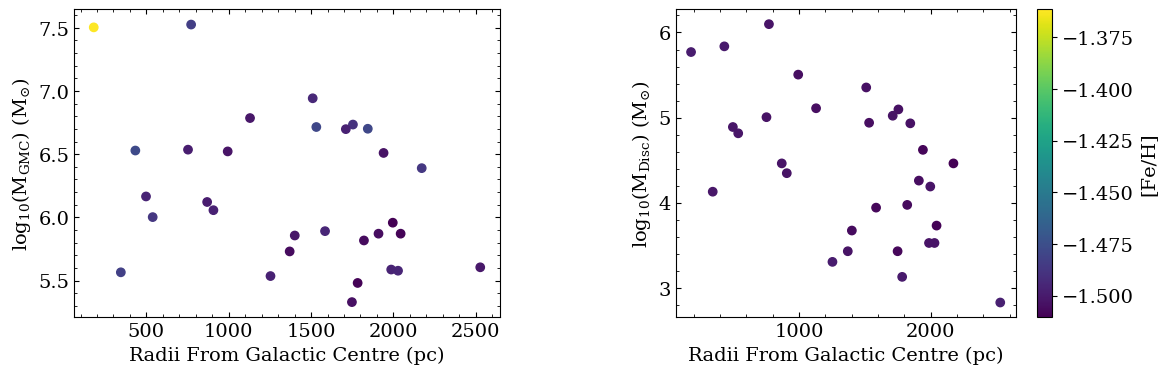

In [310]:
fig, ax = plt.subplots(figsize=(14, 4))

gs = gridspec.GridSpec(1,5, width_ratios=[1, 0.05, 0.1, 1, 0.05])  


ax0 = plt.subplot(gs[0]) # top left
ax1 = plt.subplot(gs[3]) # top middle

max_v = max(max(clump_summary.Fe_H_g), max(clump_summary.Fe_H_d))
min_v = min(min(clump_summary.Fe_H_g), min(clump_summary.Fe_H_d))

#sc = ax0.scatter(clump_summary.R_gal, np.log10(clump_summary.Gas_mass), c=clump_summary.Fe_H_g)
sc = ax0.scatter(clump_summary.R_gal, np.log10(clump_summary.Gas_mass), c=clump_summary.Fe_H_g, vmin=min_v, vmax=max_v)
ax0.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax0.set_xlabel(r'Radii From Galactic Centre (pc)')
ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

#sc1 = ax1.scatter(clump_summary.R_gal, np.log10(clump_summary.Disc_mass),c=clump_summary.Fe_H_d)
sc1 = ax1.scatter(clump_summary.R_gal, np.log10(clump_summary.Disc_mass),c=clump_summary.Fe_H_d, vmin=min_v, vmax=max_v)
ax1.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{Disc}}) \  (\rm{M}_{\odot})$')
ax1.set_xlabel(r'Radii From Galactic Centre (pc)')
ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())



#cbar = fig.colorbar(sc, ax=ax0)
cbar1 = fig.colorbar(sc1, ax=ax1)
#cbar.set_label('[Fe/H]')
cbar1.set_label('[Fe/H]')
plt.savefig("clump_mass_metal_all", bbox_inches='tight', dpi = 300)
plt.show()


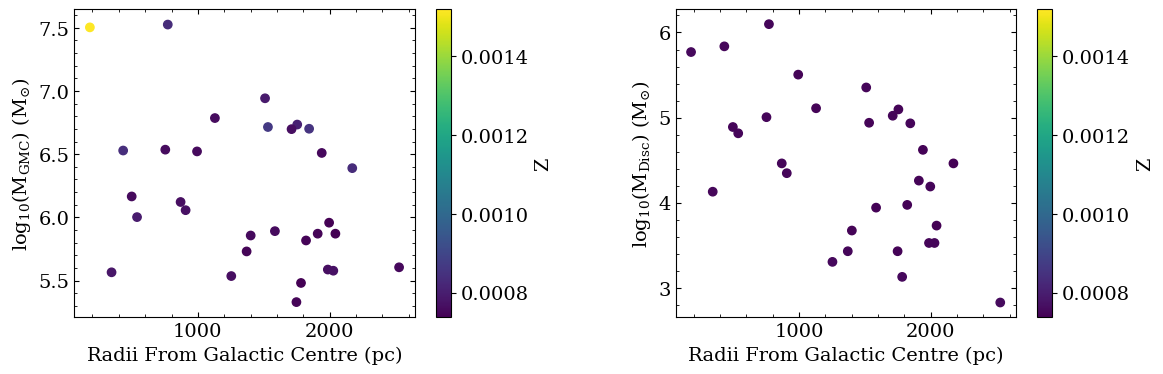

In [311]:
fig, ax = plt.subplots(figsize=(14, 4))

gs = gridspec.GridSpec(1,5, width_ratios=[1, 0.05, 0.1, 1, 0.05])  


ax0 = plt.subplot(gs[0]) # top left
ax1 = plt.subplot(gs[3]) # top middle

max_v = max(max(clump_summary.z_g), max(clump_summary.z_d))
min_v = min(min(clump_summary.z_g), min(clump_summary.z_d))


sc = ax0.scatter(clump_summary.R_gal, np.log10(clump_summary.Gas_mass), c=clump_summary.z_g, vmin=min_v, vmax=max_v)
ax0.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax0.set_xlabel(r'Radii From Galactic Centre (pc)')
ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

sc1 = ax1.scatter(clump_summary.R_gal, np.log10(clump_summary.Disc_mass),c=clump_summary.z_d, vmin=min_v, vmax=max_v)
ax1.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{Disc}}) \  (\rm{M}_{\odot})$')
ax1.set_xlabel(r'Radii From Galactic Centre (pc)')
ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())



cbar = fig.colorbar(sc, ax=ax0)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar.set_label('Z')
cbar1.set_label('Z')
plt.savefig("clump_mass_z_all", bbox_inches='tight', dpi = 300)
plt.show()

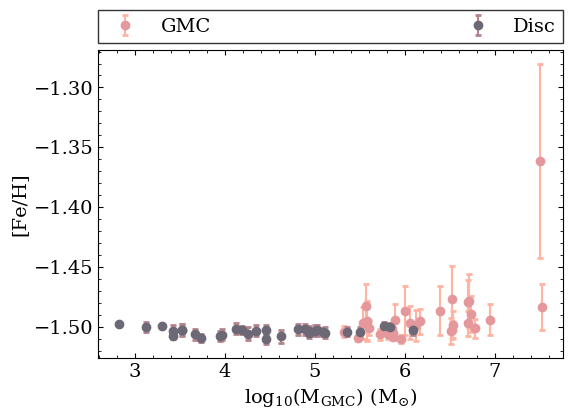

In [312]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g, yerr = clump_summary.sigma_Fe_H_g, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
             fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
plt.savefig("fe_spread_vs_mass_all", bbox_inches='tight', dpi = 300)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.show()

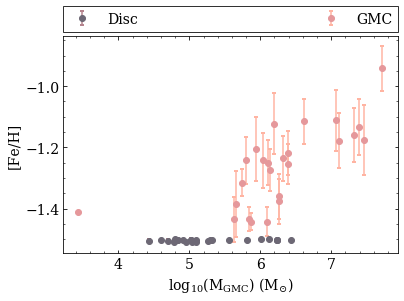

In [189]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
             fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g_HMR, yerr = clump_summary.sigma_Fe_H_g_HMR, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

/Users/maddie/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


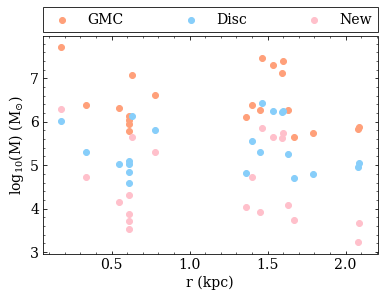

In [153]:
fig, ax = plt.subplots()
plt.scatter(clump_summary.R_gal/1000, np.log10(clump_summary.Gas_mass), color = 'lightsalmon', label = 'GMC')
plt.scatter(clump_summary.R_gal/1000, np.log10(clump_summary.Disc_mass), color = 'lightskyblue', label = 'Disc')
plt.scatter(clump_summary.R_gal/1000, np.log10(clump_summary.New_mass), color = 'pink', label = 'New')

ax.set_xlabel(r'r (kpc)')
ax.set_ylabel(r'$\rm{log}_{10} (\rm{M}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=3, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.show()

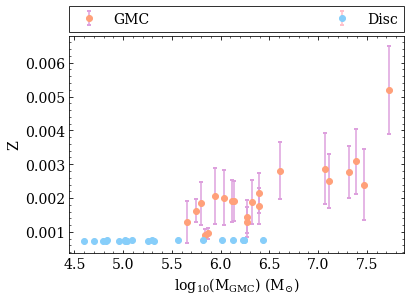

In [155]:
# colour via GMC - Disc pairs? 

fig, ax = plt.subplots()
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.z_g, yerr = clump_summary.sigma_z_g, \
             fmt='o', capthick=2, ecolor='plum', color = 'lightsalmon', label = 'GMC')
plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.z_d, yerr = clump_summary.sigma_z_d, \
             fmt='o', capthick=2, ecolor='pink', color = 'lightskyblue', label = 'Disc')
ax.set_ylabel(r'Z')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("clump_z_mass_gas", bbox_inches='tight', dpi = 300)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.show()


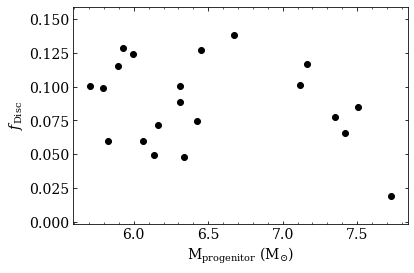

In [156]:
fig, ax = plt.subplots()
plt.scatter(np.log10(clump_summary.Gas_mass + clump_summary.Disc_mass), clump_summary.Disc_mass/(clump_summary.Gas_mass+ clump_summary.Disc_mass), color='black')
ax.set_ylabel(r'$f_{\rm{Disc}}$')
ax.set_xlabel(r'$\rm{M}_{\rm{progenitor}} \ (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
plt.savefig("f_disc", bbox_inches='tight', dpi = 300)
plt.show()

# Plots of the evolution of the galaxy

In [189]:
os.getcwd()

'/Users/maddie/Desktop/Thesis/Simulation_output/2_phase_sims/magellan3/gcmp38/1_output_visualisation'

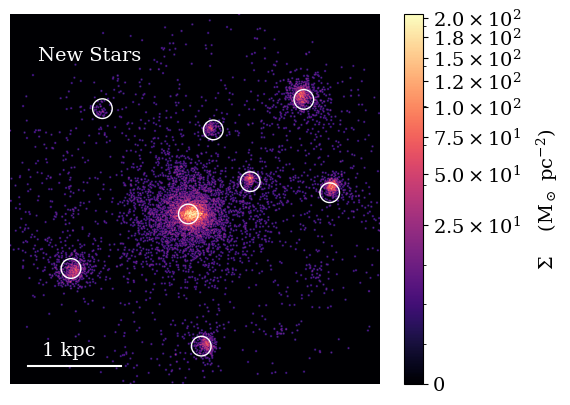

In [118]:
rang = 2000
bin_size = 4000
cmap = plt.cm.get_cmap('magma')
gamma = 0.4
i = 6
hist1, xedges, yedges = np.histogram2d(df_n[i].x, df_n[i].y, bins = bin_size, weights = df_n[i].mass, range=([-rang,rang],[-rang,rang]))
smoothing_sigma = 5
hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
fig, ax1 = plt.subplots()

im2 = ax1.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax1.plot([-1800,-800], [-1800, -1800], color='white')
cbar = fig.colorbar(im2, ax=ax1, format=ticker.FuncFormatter(fmt))
ax1.text(time_x, time_y, 'New Stars', color='white')
ax1.scatter(max_x[clump_numbers], max_y[clump_numbers], s=200, facecolors='none', edgecolors='white')
#ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_ylabel('Y (pc)')
ax1.set_xlabel('X (pc)')
#ax1.set_title('$\Sigma_{ H_2 }$')
cbar.set_label(r'$\Sigma $    (M$_\odot$ pc$^{-2}$)', labelpad = 10)
plt.axis('off')
cbar.ax.minorticks_on()
ax1.text(-1650, -1700, '1 kpc', c = 'white')
#plt.savefig('new_stars'+ str(i), bbox_inches='tight', dpi = 300)
plt.show()

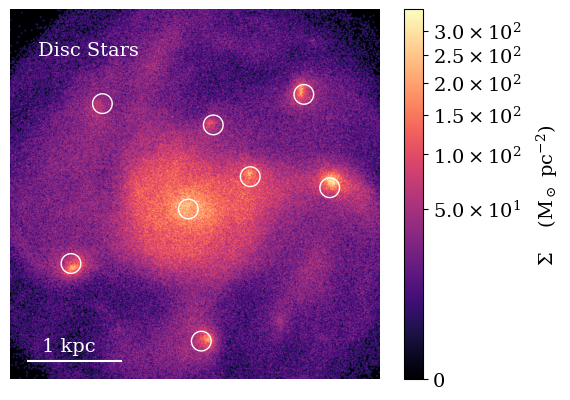

In [117]:
rang = 2000
bin_size = 4000
cmap = plt.cm.get_cmap('magma')
gamma = 0.4
i = 6
hist1, xedges, yedges = np.histogram2d(df_d[i].x, df_d[i].y, bins = bin_size, weights = df_d[i].mass, range=([-rang,rang],[-rang,rang]))
smoothing_sigma = 5
hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
fig, ax1 = plt.subplots()

im2 = ax1.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax1.plot([-1800,-800], [-1800, -1800], color='white')
cbar = fig.colorbar(im2, ax=ax1, format=ticker.FuncFormatter(fmt))
ax1.text(time_x, time_y, 'Disc Stars', color='white')
ax1.scatter(max_x[clump_numbers], max_y[clump_numbers], s=200, facecolors='none', edgecolors='white')
#ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_ylabel('Y (pc)')
ax1.set_xlabel('X (pc)')
#ax1.set_title('$\Sigma_{ H_2 }$')
cbar.set_label(r'$\Sigma $    (M$_\odot$ pc$^{-2}$)', labelpad = 10)
plt.axis('off')
#cbar.ax.minorticks_on()
ax1.text(-1650, -1700, '1 kpc', c = 'white')
#plt.savefig('Disc'+ str(i), bbox_inches='tight', dpi = 300)
plt.show()

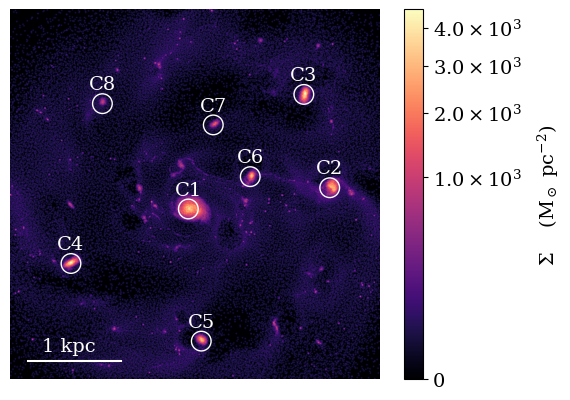

In [115]:
# Enter in the ordering of the most massive clumps

# for 50
#clump_numbers = [0,1,3,6,5,2,4,10]

# For 38
clump_numbers = [2,5,0,1,3,4,6,13]

#for 55
#clump_numbers = [0,1,2,5,4,6, 7, 10]

rang = 2000
bin_size = 4000
cmap = plt.cm.get_cmap('magma')
gamma = 0.4
i = 6
hist1, xedges, yedges = np.histogram2d(df_g[i].x, df_g[i].y, bins = bin_size, weights = df_g[i].mass, range=([-rang,rang],[-rang,rang]))
smoothing_sigma = 5
hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
fig, ax1 = plt.subplots()

im2 = ax1.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap)
ax1.plot([-1800,-800], [-1800, -1800], color='white')
cbar = fig.colorbar(im2, ax=ax1, format=ticker.FuncFormatter(fmt))

ax1.scatter(max_x[clump_numbers], max_y[clump_numbers], s=200, facecolors='none', edgecolors='white')
#ax1.scatter(max_x, max_y, s=100, facecolors='none', edgecolors='white')
ax1.set_ylabel('Y (pc)')
ax1.set_xlabel('X (pc)')
#ax1.set_title('$\Sigma_{ H_2 }$')
cbar.set_label(r'$\Sigma $    (M$_\odot$ pc$^{-2}$)', labelpad = 10)
plt.axis('off')

ax1.text(-1650, -1700, '1 kpc', c = 'white')

#offset value
ov_x = -150
ov_y = 150

ax1.text(max_x[clump_numbers[0]]+ov_x, max_y[clump_numbers[0]]+ov_y, 'C1', color='white')
ax1.text(max_x[clump_numbers[1]]+ov_x, max_y[clump_numbers[1]]+ov_y, 'C2', color='white')
ax1.text(max_x[clump_numbers[2]]+ov_x, max_y[clump_numbers[2]]+ov_y, 'C3', color='white')
ax1.text(max_x[clump_numbers[3]]+ov_x, max_y[clump_numbers[3]]+ov_y, 'C4', color='white')
ax1.text(max_x[clump_numbers[4]]+ov_x, max_y[clump_numbers[4]]+ov_y, 'C5', color='white')
ax1.text(max_x[clump_numbers[5]]+ov_x, max_y[clump_numbers[5]]+ov_y, 'C6', color='white')
ax1.text(max_x[clump_numbers[6]]+ov_x, max_y[clump_numbers[6]]+ov_y, 'C7', color='white')
ax1.text(max_x[clump_numbers[7]]+ov_x, max_y[clump_numbers[7]]+ov_y, 'C8', color='white')


plt.savefig('clump_ID'+ str(i), bbox_inches='tight', dpi = 300)
plt.show()

256.79352 391.5


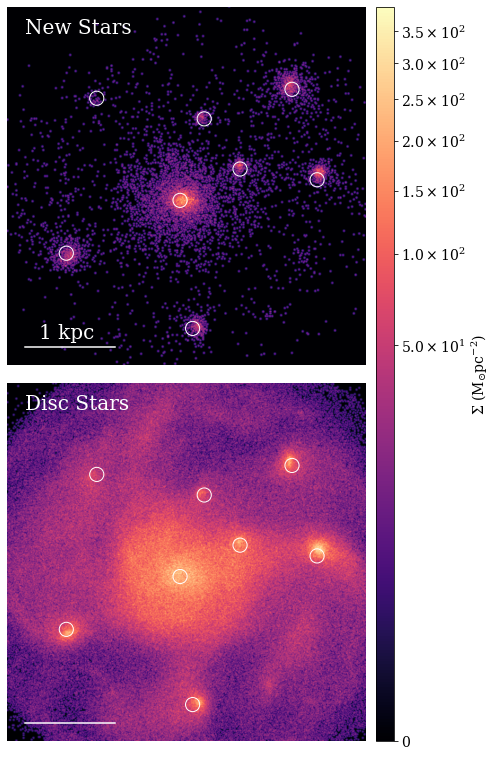

In [279]:
rang = 2000
bin_size = 400
hist1, xedges, yedges = np.histogram2d(df_n[-1].x, df_n[-1].y, bins = bin_size, weights = df_n[-1].mass, range=([-rang,rang],[-rang,rang]))
hist2, xedges, yedges = np.histogram2d(df_d[-1].x, df_d[-1].y, bins = bin_size, weights = df_d[-1].mass, range=([-rang,rang],[-rang,rang]))

gamma = 0.3
# / by 10^2
hist1 /=100
hist2 /=100


max_1 = np.max(hist1)
max_2 = np.max(hist2)
print(max_1, max_2)

all_max_1 = np.max([max_1, max_2])


fig = plt.figure()
fig.set_size_inches(6,12)
gs = fig.add_gridspec(2,2, width_ratios=[1,0.05])  


cbax1 = plt.subplot(gs[:,1])

ax0 = plt.subplot(gs[0,0]) # top 
ax1 = plt.subplot(gs[1,0]) # bottom

im1 =ax0.imshow(hist1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap, vmax = all_max_1, interpolation = 'gaussian')

ax1.imshow(hist2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap, vmax = all_max_1, interpolation = 'gaussian')

time_x = -1800
time_y = 1700

ax0.text(time_x, time_y, 'New Stars', color='white', fontsize=20)
ax1.text(time_x, time_y, 'Disc Stars', color='white', fontsize=20)

ax0.scatter(max_x[clump_numbers], max_y[clump_numbers], s=200, facecolors='none', edgecolors='white')
ax1.scatter(max_x[clump_numbers], max_y[clump_numbers], s=200, facecolors='none', edgecolors='white')


scale_bar_x = [-1800,-800]
scale_bar_y = [-1800, -1800]

scale_text_x = -1700
scale_text_y = -1700
ax0.text(-1650, -1700, '1 kpc', c = 'white', fontsize=20)
ax0.plot(scale_bar_x, scale_bar_y, color='white')
ax1.plot(scale_bar_x, scale_bar_y, color='white')

ax0.axis('off')
ax1.axis('off')



cb1 = Colorbar(ax = cbax1, mappable = im1, format=ticker.FuncFormatter(fmt))
cb1.set_label(r'$\Sigma \ (\rm{M}_{\odot} \rm{pc}^{-2})$')
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.05, hspace=0.05)   
plt.savefig('new_disc'+ str(i), bbox_inches='tight', dpi = 300)
plt.show()